In [386]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# RBF NET Using predefined Centres and Sigmas using Kmeans

In [947]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

In [948]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
 
    return clusters, stds

In [949]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=10, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
 
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
        
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b

                loss = (y[i] - F).flatten() ** 2
                #print('Loss: {0:.2f}'.format(loss[0]))

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
                
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

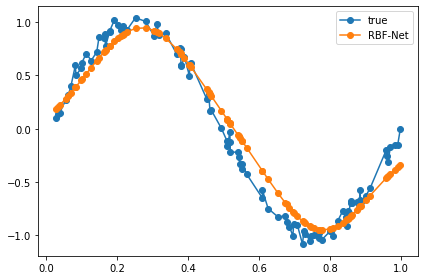

In [950]:
# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise
 
rbfnet = RBFNet(lr=1e-2, k=2)
rbfnet.fit(X, y)
 
y_pred = rbfnet.predict(X)
 
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()